In [71]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
tmp=loadmat(r'C:\Users\vishw\Downloads\dataset.mat',struct_as_record=True)

In [72]:
#    load data from the file
xdata=np.array(tmp['EEGsample'])
label=np.array(tmp['substate'])
subIdx=np.array(tmp['subindex'])

label.astype(int)
subIdx.astype(int)
    
samplenum=label.shape[0]
    
#   there are 11 subjects in the dataset. Each sample is 3-seconds data from 30 channels with sampling rate of 128Hz. 
channelnum=30
subjnum=11
samplelength=3
sf=128

#   ydata contains the label of samples   
ydata=np.zeros(samplenum,dtype=np.longlong)
    
for i in range(samplenum):
    ydata[i]=label[i]


In [73]:
import mne

In [74]:
channel_names=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8','T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'Oz','O2']

In [75]:
#initialize an info structure
info=mne.create_info(
    ch_names=channel_names,
    ch_types=['eeg']*channelnum,
    sfreq=sf)
print('Event created:',info)

Event created: <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FT7, FC3, FCZ, FC4, FT8, T3, C3, ...
 chs: 30 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 30
 projs: []
 sfreq: 128.0 Hz
>


In [76]:
raw=mne.io.RawArray(xdata[0],info)

Creating RawArray with float64 data, n_channels=30, n_times=384
    Range : 0 ... 383 =      0.000 ...     2.992 secs
Ready.


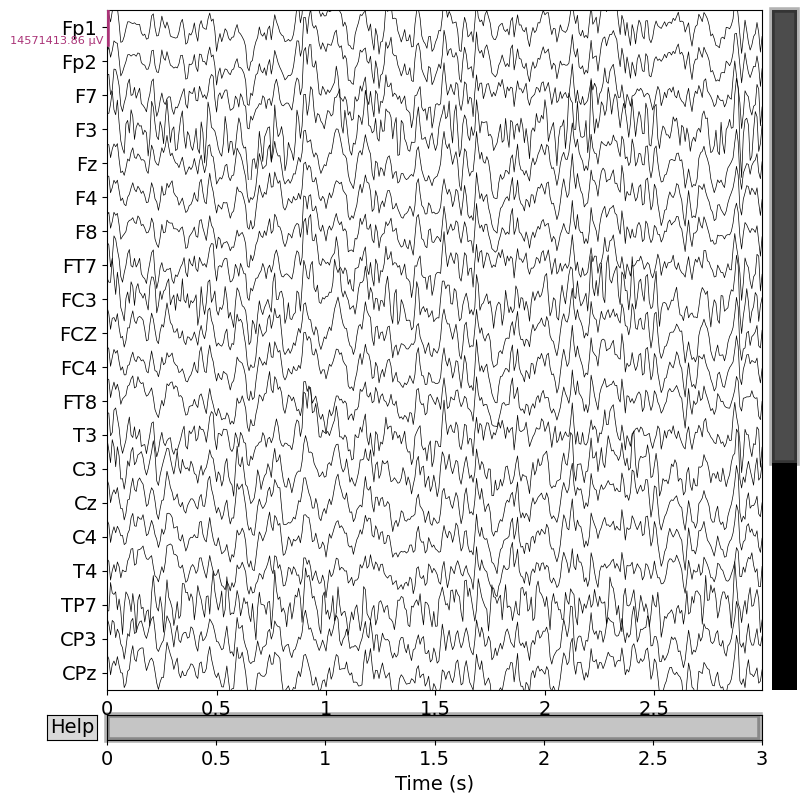

In [77]:
raw.plot(scalings='auto');

## Creating Events

In [78]:
#creating event id, 1 for drowsy and 0 for alert
event_id=dict(alert=0,drowsy=1)

In [79]:
tmp["substate"].shape

(2022, 1)

In [80]:
# Create an event matrix: events with alternating event codes
eventLength = tmp["substate"].shape[0]
Y = tmp["substate"].flatten()
ev = [i*sf*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(eventLength,  dtype = int),
                          np.array(Y,  dtype = int)))

## Epochs

In [81]:
#The time window(in samples) to extract for each trial
tmin=0.5

#create the :class: mne.EpochsArray object
epochs=mne.EpochsArray(xdata,info,events,tmin,event_id)

# # Convert the dictionary to a Pandas DataFrame

# subindex = tmp['subindex'].flatten()  
# substate = tmp['substate'].flatten() 
# metadata_df = pd.DataFrame({'subject': subindex, 'state': substate})

# # Assign the DataFrame to the metadata attribute
# epochs.metadata = metadata_df

Not setting metadata
2022 matching events found
No baseline correction applied
0 projection items activated


In [82]:
events

array([[     0,      0,      0],
       [   384,      0,      0],
       [   768,      0,      0],
       ...,
       [775296,      0,      1],
       [775680,      0,      1],
       [776064,      0,      1]])

## Visualization

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\vishw\AppData\Local\Temp\ipykernel_11940\3011794035.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd()
C:\Users\vishw\AppData\Local\Temp\ipykernel_11940\3011794035.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()
C:\Users\vishw\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


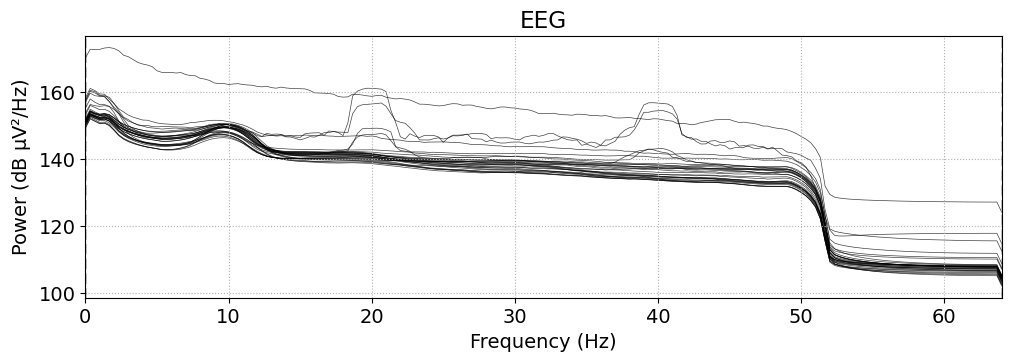

In [83]:
#plotting the psd curve
epochs.plot_psd()

Not setting metadata
2022 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


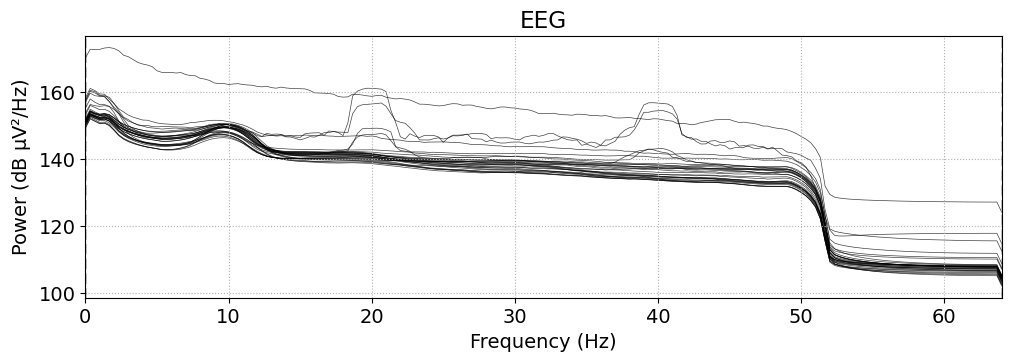

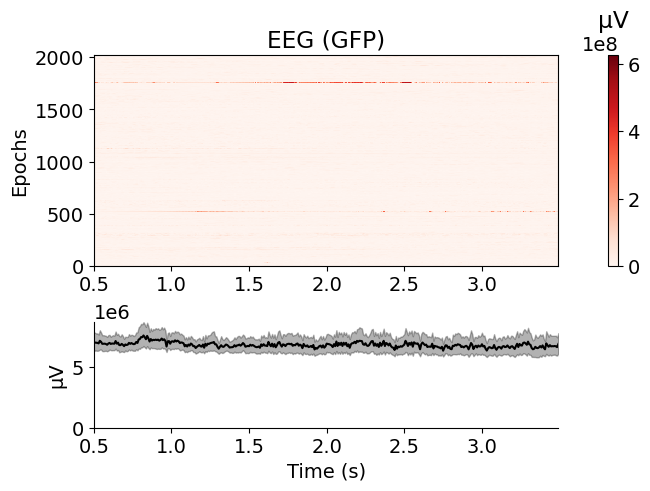

In [84]:
epochs.plot_image();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


C:\Users\vishw\AppData\Local\Temp\ipykernel_11940\3404087069.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.average().plot_psd()
C:\Users\vishw\AppData\Local\Temp\ipykernel_11940\3404087069.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.average().plot_psd()
C:\Users\vishw\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


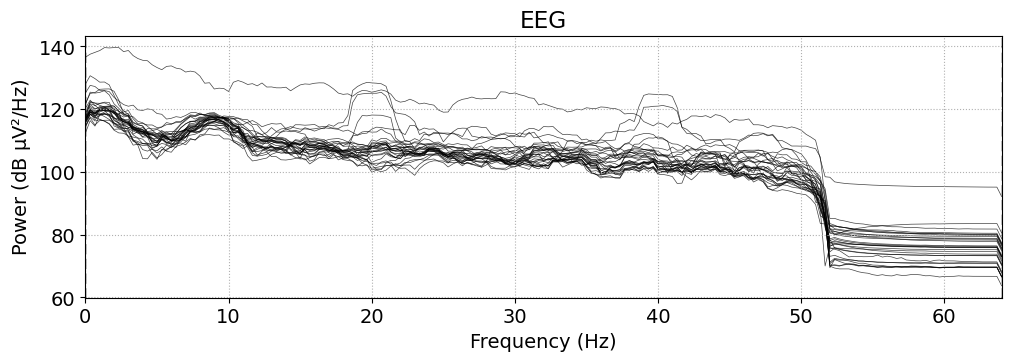

In [85]:
epochs.average().plot_psd()

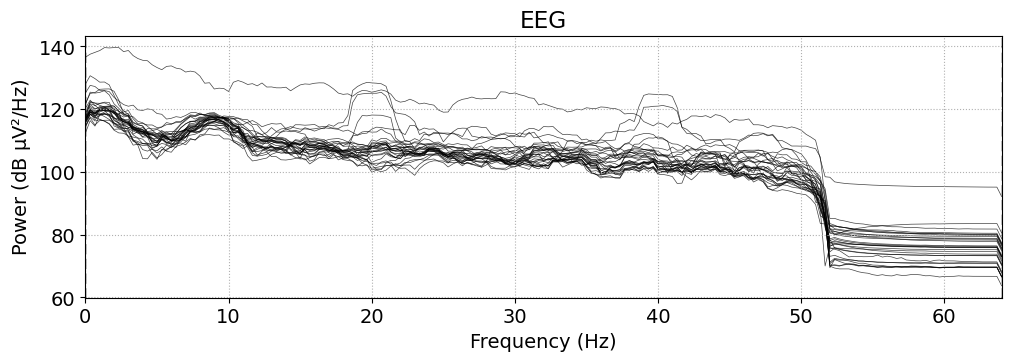

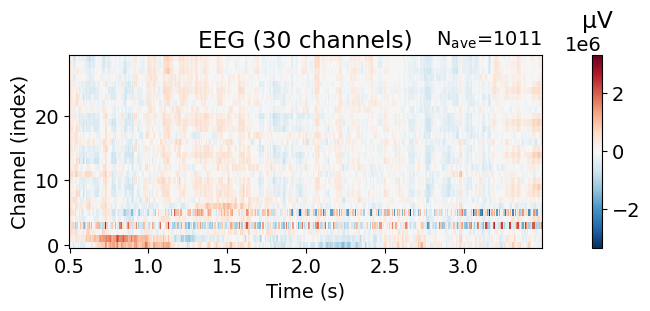

In [86]:
epochs["alert"].average().plot_image();

## CNN Model

In [87]:
!pip install torch

In [88]:
import torch

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io as sio
from sklearn.metrics import accuracy_score

# creating Interpretable CNN model:
# consists of seven layers: pointwise conv,depthwise conv,activation layer,batch normalization layer,avg pooling,linear,softmax

class InterpretableCNN(nn.Module):  
    def __init__(self, classes=2, sampleChannel=30, sampleLength=384, N1=16, d=2, kernelLength=64):
        super(InterpretableCNN, self).__init__()
        self.pointwise = nn.Conv2d(1, N1, (sampleChannel, 1))
        self.depthwise = nn.Conv2d(N1, d * N1, (1, kernelLength), groups=N1)
        self.activ = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(d * N1, track_running_stats=False)
        self.GAP = nn.AvgPool2d((1, sampleLength - kernelLength + 1))
        self.fc = nn.Linear(d * N1, classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputdata):
        intermediate = self.pointwise(inputdata)
        intermediate = self.depthwise(intermediate)
        intermediate = self.activ(intermediate)
        intermediate = self.batchnorm(intermediate)
        intermediate = self.GAP(intermediate)
        intermediate = intermediate.view(intermediate.size()[0], -1)
        intermediate = self.fc(intermediate)
        output = self.softmax(intermediate)
        return output


In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io as sio
from sklearn.metrics import accuracy_score

class InterpretableCNN(nn.Module):  
    def __init__(self, classes=2, sampleChannel=30, sampleLength=384, N1=16, d=2, kernelLength=64):
        super(InterpretableCNN, self).__init__()
        self.pointwise = nn.Conv2d(1, N1, (sampleChannel, 1))
        self.depthwise = nn.Conv2d(N1, d * N1, (1, kernelLength), groups=N1)
        self.activ = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(d * N1, track_running_stats=False)
        self.GAP = nn.AvgPool2d((1, sampleLength - kernelLength + 1))
        self.fc = nn.Linear(d * N1, classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputdata):
        intermediate = self.pointwise(inputdata)
        intermediate = self.depthwise(intermediate)
        intermediate = self.activ(intermediate)
        intermediate = self.batchnorm(intermediate)
        intermediate = self.GAP(intermediate)
        intermediate = intermediate.view(intermediate.size()[0], -1)
        intermediate = self.fc(intermediate)
        output = self.softmax(intermediate)
        return output
# this is the code that will run on CPU nd not on GPU
def run():
    # Load data from the file (assuming 'tmp' contains your data)
    xdata = np.array(tmp['EEGsample'])
    label = np.array(tmp['substate'])
    subIdx = np.array(tmp['subindex'])

    label = label.astype(int)
    subIdx = subIdx.astype(int)
    
    samplenum = label.shape[0]
    
    # Dataset parameters
    channelnum = 30
    subjnum = 11
    samplelength = 3
    sf = 128
    # channelnum: Number of channels in the EEG data.
    # classes: Number of classes (alert and drowsy).
    # subjnum: Number of subjects in the dataset.
    # samplelength: Length of each sample in seconds.
    
    # Training parameters
    lr = 1e-3 #Sets the learning rate for the optimizer to 0.001
    batch_size = 50
    n_epoch = 11 
    
    ydata = label.flatten()
    
    results = np.zeros(subjnum)
    
    # Leave-one-subject-out cross-validation
    for i in range(1, subjnum + 1):
        # Form the training data  
        
        # trainindx: Indices of samples not belonging to subject i (used for training).
        # xtrain: Training samples based on trainindx.
        # x_train: Reshapes xtrain to include channel and sample length dimensions.
        # y_train: Training labels based on trainindx.
        # testindx: Indices of samples belonging to subject i (used for testing).
        # y_test: Testing labels based on testindx.
        
        trainindx = np.where(subIdx != i)[0] 
        xtrain = xdata[trainindx]   
        x_train = xtrain.reshape(xtrain.shape[0], 1, channelnum, samplelength * sf)
        y_train = ydata[trainindx]
        
        # Form the testing data         
        testindx = np.where(subIdx == i)[0]    
        xtest = xdata[testindx]
        x_test = xtest.reshape(xtest.shape[0], 1, channelnum, samplelength * sf)
        y_test = ydata[testindx]
    
        # Convert labels to torch.long
        y_train_tensor = torch.from_numpy(y_train).long()
        
        train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train), y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Load the CNN model
        my_net = InterpretableCNN().double()
        optimizer = optim.Adam(my_net.parameters(), lr=lr)    
        loss_class = nn.NLLLoss()

        for epoch in range(n_epoch):   
            for j, data in enumerate(train_loader, 0):
                inputs, labels = data                
                inputs, labels = inputs, labels

                my_net.zero_grad()               
                my_net.train()          
   
                class_output = my_net(inputs) 
                err_s_label = loss_class(class_output, labels)
                err = err_s_label 
             
                err.backward()
                optimizer.step()

        # Test the results
        my_net.eval()
        with torch.no_grad():
            x_test_tensor = torch.DoubleTensor(x_test)
            answer = my_net(x_test_tensor)
            probs = answer.numpy()
            preds = probs.argmax(axis=-1)  
            acc = accuracy_score(y_test, preds)

            print(f'Accuracy for subject {i}: {acc}')
            results[i-1] = acc
            
    print('Mean accuracy:', np.mean(results))

if __name__ == '__main__':
    torch.manual_seed(0)
    run()


Accuracy for subject 1: 0.8563829787234043
Accuracy for subject 2: 0.696969696969697
Accuracy for subject 3: 0.7866666666666666
Accuracy for subject 4: 0.7837837837837838
Accuracy for subject 5: 0.8794642857142857
Accuracy for subject 6: 0.8433734939759037
Accuracy for subject 7: 0.6666666666666666
Accuracy for subject 8: 0.7878787878787878
Accuracy for subject 9: 0.89171974522293
Accuracy for subject 10: 0.7314814814814815
Accuracy for subject 11: 0.6592920353982301
Mean accuracy: 0.7803345111347126


## Final Visualization

In [91]:
import scipy.integrate
dir(scipy.integrate)


['AccuracyWarning',
 'BDF',
 'DOP853',
 'DenseOutput',
 'IntegrationWarning',
 'LSODA',
 'OdeSolution',
 'OdeSolver',
 'RK23',
 'RK45',
 'Radau',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_bvp',
 '_dop',
 '_ivp',
 '_lsoda',
 '_ode',
 '_odepack',
 '_odepack_py',
 '_quad_vec',
 '_quadpack',
 '_quadpack_py',
 '_quadrature',
 '_vode',
 'complex_ode',
 'cumtrapz',
 'cumulative_trapezoid',
 'dblquad',
 'dop',
 'fixed_quad',
 'lsoda',
 'newton_cotes',
 'nquad',
 'ode',
 'odeint',
 'odepack',
 'quad',
 'quad_vec',
 'quadpack',
 'quadrature',
 'romb',
 'romberg',
 'simps',
 'simpson',
 'solve_bvp',
 'solve_ivp',
 'test',
 'tplquad',
 'trapezoid',
 'trapz',
 'vode']

In [92]:
import torch
import scipy.io as sio
import numpy as np
import torch.optim as optim
from scipy.integrate import simps
from mne.time_frequency import psd_array_multitaper
import mne
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

#Clearing GPU cache and setting seed for reproducibility
torch.cuda.empty_cache()
torch.manual_seed(0)

# Setting plot font size
plt.rcParams.update({'font.size': 14})

class VisTech():
    def __init__(self, model):
        self.model = model
        self.model.eval()

    # Now this model Calculates the heatmap based on the activations of a specific sample.
    # Steps include :1)obtaining layer activations
    # 2)calculating Class Activation Maps (CAM)
    # 3) generating the heatmap
    # basically what it does is that it computes a heatmap for a given sample input, which highlights the most discriminative parts of the input signal that contribute to the model's prediction. 
    def heatmap_calculation(self,batchInput,sampleidx,state,radius=32):
        
        # to get the activations after the 4th layer
        # Obtains the activations of the batchInput after each layer of the model up to the 4th layer
        batchActiv1=self.model.pointwise(batchInput) 
        batchActiv2=self.model.depthwise(batchActiv1)         
        batchActiv3=self.model.activ(batchActiv2)  
        batchActiv4=self.model.batchnorm(batchActiv3)     
        
        # to get the parameters of the network
        # Extracts the weights of the model's pointwise, depthwise, and fully connected (fc) layers.
        layer1weights=self.model.pointwise.weight.cpu().detach().numpy().squeeze()
        layer2weights=self.model.depthwise.weight.detach().cpu().numpy().squeeze()         
        layer6weights=torch.transpose(self.model.fc.weight,0,1).cpu().detach().numpy().squeeze()
        
        # to get activations of the sample
        sampleInput=batchInput[sampleidx].cpu().detach().numpy().squeeze()        
        sampleActiv2=batchActiv2[sampleidx].cpu().detach().numpy().squeeze()        
        sampleActiv4=batchActiv4[sampleidx].cpu().detach().numpy().squeeze()
        
        # to get the dimensional of the input sample and the kernel length of the second layer
        # Determines the number of channels and length of the sample input, and calculates the kernel length used in the second layer.
        sampleChannel=sampleInput.shape[0] 
        sampleLength=sampleInput.shape[1]
        kernelLength=sampleLength-sampleActiv4.shape[1]+1

        #the class activation map
        # Computes the CAM by element-wise multiplying the activations from the 4th layer by the weights of the fully connected layer corresponding to the target state.
        CAM=sampleActiv4*np.tile(np.array([layer6weights[:,state]]).transpose(),(1,sampleActiv4.shape[1]))
        CAMsorted=np.sort(CAM,axis=None)
        
        #threshold of the class activation map
        CAMthres=CAMsorted[-100]
        
        # the fixationmap regesters locations of the discriminative points
        # Creates a fixation map where each point is set to True if its CAM value is greater than the threshold.
        fixationmap=CAM>CAMthres
        
        #the activations after 2nd layer and those after 4th layer must have the same signs. Otherwise, you need to change the CAM threshold.
        for i in range(fixationmap.shape[0]):
            for j in range(fixationmap.shape[1]):
                if fixationmap[i,j]:
                    if sampleActiv4[i,j]*sampleActiv2[i,j]<0:
                        fixationmap[i,j]=False
                        print('error')
              
        # the corresponding discriminative locations for the input sample
        fixationmap0=np.zeros((sampleChannel,sampleLength)) 

        # find the corresponding discriminative locations for the input sample
        for i in range(fixationmap.shape[0]):
            for j in range(fixationmap.shape[1]): 
                if fixationmap[i,j]:
                    #Implement equation (13) in the paper
                    sumvalue=np.sum(sampleInput[:,j:j+64]*np.tile(layer2weights[i,:],(sampleChannel,1)),axis=1)*layer1weights[int(np.floor(i/2)),:]
                    # implement equation (14) in the paper
                    p=np.argmax(sumvalue*np.sign(sampleActiv2[i,j]))
                    # implement equation (15) in the paper
                    q=j+int(kernelLength/2)
                    
                    fixationmap0[p,q]=1
          
        # calculate the final heatmap    
        # initializes the heatmap and then populates it by spreading the activation from each fixation point using a Gaussian function, controlled by the radius parameter
        heatmap=np.zeros((sampleChannel,sampleLength))             
        for p in range(sampleChannel):
            for q in range(sampleLength):
                if fixationmap0[p,q]>0:
                                        
                    minbound=int(q-radius)
                    if minbound<0:
                        minbound=0
                        
                    maxbound=int(q+radius)
                    if maxbound>sampleLength:
                        maxbound=sampleLength
                    
                    for qk in range(minbound,maxbound):
                        # implement equation (12) in the paper
                        heatmap[p,qk]=heatmap[p,qk]+ 1 / radius/np.sqrt(2 * np.pi) *np.exp(-(qk-q)** 2/(2*radius*radius))
        
        # normalize the heatmap for visualization
        # Normalizes the heatmap for visualization by subtracting the mean and scaling by the standard deviation.
        heatmap= (heatmap-np.mean(heatmap)) / np.sqrt(np.sum(heatmap**2)/(sampleChannel*sampleLength))  
                
        return heatmap   
               

    # Now the below function Generates and plots the heatmap along with other relevant visualizations like topographic map
    # Includes spectral power calculations for different EEG frequency bands (delta, theta, alpha, beta).
    
    def generate_heatmap(self, batchInput,sampleidx,subid,samplelabel,likelihood):

        # Determines the predicted state (class) by comparing the likelihoods. 
        # state is set to 0 if the probability of being alert is higher, and 1 if the probability of being drowsy is higher.
        if likelihood[0]>likelihood[1]:
            state=0
        else:
            state=1

        # Converts the numeric sample label to a string for display purposes.

        if samplelabel==0:
            labelstr='alert'
        else:
            labelstr='drowsy'        
        
        
        sampleInput=batchInput[sampleidx].detach().numpy().squeeze()
        sampleChannel=sampleInput.shape[0] 
        sampleLength=sampleInput.shape[1]        
        
        
        heatmap=self.heatmap_calculation(batchInput=batchInput,sampleidx=sampleidx,state=state)

        # Creates a figure with a specific size and grid layout, and defines subplots for various visualizations.
        fig = plt.figure(figsize=(23,6))
        
        gridlayout = gridspec.GridSpec(ncols=6, nrows=2, figure=fig,wspace=0.05, hspace=0.005)

        axs0 = fig.add_subplot(gridlayout[0:2,0:2])
        axs1 = fig.add_subplot(gridlayout[0:2,2:4])  
        axs21= fig.add_subplot(gridlayout[0,4]) 
        axs22= fig.add_subplot(gridlayout[0,5]) 
        axs23= fig.add_subplot(gridlayout[1,4]) 
        axs24= fig.add_subplot(gridlayout[1,5])        

    
        fig.suptitle('Subject:'+str(int(subid))+'   '+'Label:'+labelstr+'   '+'$P_{alert}=$'+str(round(likelihood[0],2))+'   $P_{drowsy}=$'+str(round(likelihood[1],2)),y=1.02)  
        thespan=np.percentile(sampleInput,98)        
        
        xx=np.arange(1,sampleLength+1) 
        # Plots each EEG channel signal with a vertical offset and overlays the heatmap using a color gradient.
        for i in range(0,sampleChannel):            
            y=sampleInput[i,:]+thespan*(sampleChannel-1-i)
            dydx=heatmap[i,:]           
          
            points = np.array([xx, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            norm = plt.Normalize(-1, 1)
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            axs0.add_collection(lc)

        
        # Configures the y-axis ticks to correspond to the EEG channel names and offsets.
        # Sets the x-axis and y-axis limits and labels.
        # Uses inverse channel names to match the plot's orientation.
        
        yttics=np.zeros(sampleChannel)
        for gi in range(sampleChannel):
            yttics[gi]=gi*thespan

        axs0.set_ylim([-thespan,thespan*sampleChannel])          
        axs0.set_xlim([0,sampleLength+1]) 
        axs0.set_xticks([1,100,200,300,384])        
        
        channelnames=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8','T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'Oz','O2']
 
        inversechannelnames=[]
        for i in range(sampleChannel):
            inversechannelnames.append(channelnames[sampleChannel-1-i])
                   
        plt.sca(axs0)
        plt.yticks(yttics, inversechannelnames)        
        
        deltapower=np.zeros(sampleChannel)
        thetapower=np.zeros(sampleChannel)
        alphapower=np.zeros(sampleChannel)
        betapower=np.zeros(sampleChannel)
        
        for kk in range(sampleChannel):
            psd, freqs = psd_array_multitaper(sampleInput[kk,:], 128, adaptive=True,normalization='full', verbose=0)
            freq_res = freqs[1] - freqs[0]

            totalpower=simps(psd, dx=freq_res)
            if totalpower<0.00000001:
               deltapower[kk]=0
               thetapower[kk]=0
               alphapower[kk]=0
               betapower[kk]=0
            else:
                idx_band = np.logical_and(freqs >= 1, freqs <= 4)
                deltapower[kk] = simps(psd[idx_band], dx=freq_res)/totalpower
                idx_band = np.logical_and(freqs >= 4, freqs <= 8)
                thetapower[kk]  = simps(psd[idx_band], dx=freq_res)/totalpower
                idx_band = np.logical_and(freqs >= 8, freqs <= 12)
                alphapower[kk]  = simps(psd[idx_band], dx=freq_res)/totalpower       
                idx_band = np.logical_and(freqs >= 12, freqs <= 30)
                betapower[kk]  = simps(psd[idx_band], dx=freq_res)/totalpower

        # Sets titles for the subplots corresponding to each frequency band
        axs21.set_title('Delta',y=-0.2)
        axs22.set_title('Theta',y=-0.2)
        axs23.set_title('Alpha',y=-0.2)
        axs24.set_title('Beta',y=-0.2)

        montage =mne.channels.make_standard_montage('standard_1020')#I used standard montage as the dataset has no digitization points
        sfreq = 128
        
        ch_names=channelnames
        
        info = mne.create_info(
            channelnames,
            ch_types=['eeg']*sampleChannel,
            sfreq=sfreq,          
        )

        #apply montage
        info.set_montage(montage,on_missing='ignore') #ignore missing channels
        topoHeatmap = np.mean(heatmap, axis=1)
        im,cn=mne.viz.plot_topomap(data=topoHeatmap,pos=info, axes=axs1, names=ch_names,outlines='head',cmap='viridis',show=False)
        fig.colorbar(im,ax=axs1)

        mixpower=np.zeros((4,sampleChannel))
        mixpower[0,:]=deltapower
        mixpower[1,:]=thetapower
        mixpower[2,:]=alphapower
        mixpower[3,:]=betapower

        vmax=np.percentile(mixpower,95)        

        # Plots topomaps for delta, theta, alpha, and beta power values using MNE's plot_topomap function.
        
        im,cn=mne.viz.plot_topomap(data=deltapower,pos=info, axes=axs21, names=ch_names,outlines='head',cmap='viridis',show=False)
        im,cn=mne.viz.plot_topomap(data=thetapower,pos=info, axes=axs22, names=ch_names,outlines='head',cmap='viridis',show=False)
        im,cn=mne.viz.plot_topomap(data=alphapower,pos=info, axes=axs23, names=ch_names,outlines='head',cmap='viridis',show=False)
        im,cn=mne.viz.plot_topomap(data=betapower,pos=info,  axes=axs24, names=ch_names,outlines='head',cmap='viridis',show=False)
   
        fig.colorbar(im,ax=[axs21,axs22,axs23,axs24])
       

def run():

    lr = 1e-3   
 
    channelnum=30
    classes=2
    subjnum=11
    samplelength=3
   
    xdata=np.array(tmp['EEGsample'])
    label=np.array(tmp['substate'])
    subIdx=np.array(tmp['subindex'])

    label.astype(int)    
    subIdx.astype(int)

    samplenum=label.shape[0]
    sf=128
    ydata=np.zeros(samplenum,dtype=np.longlong)
    
    for i in range(samplenum):
        ydata[i]=label[i]

    batch_size = 50   
    n_epoch =11    

    for i in range(1,2):
        trainindx=np.where(subIdx != i)[0] 
        xtrain=xdata[trainindx]   
        x_train = xtrain.reshape(xtrain.shape[0],1,channelnum, samplelength*sf)
      
        y_train=ydata[trainindx]               
        testindx=np.where(subIdx == i)[0]    
        
        y_test=ydata[testindx]
    
        train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

        my_net = InterpretableCNN().double()
        optimizer = optim.Adam(my_net.parameters(), lr=lr)    
        loss_class = torch.nn.NLLLoss()

        for p in my_net.parameters():
            p.requires_grad = True    
        
        for epoch in range(n_epoch):  
            for j, data in enumerate(train_loader, 0):
                inputs, labels = data                
                
                input_data = inputs.double()
                class_label = labels.long()              
           
                my_net.train()          
                my_net.zero_grad()    
                class_output= my_net(input_data) 
                err_s_label = loss_class(class_output, class_label)
                err = err_s_label 
  
                err.backward()
                optimizer.step()

        # Disables gradient calculation, which reduces memory usage and speeds up computations during inference.
        # softmax: Applies the softmax function along dimension 1 to convert the model's raw outputs into probabilities.
        # likelihood: The predicted probabilities for each class (alert and drowsy) for each sample in the batch
        my_net.eval()
        with torch.no_grad():
            xtest=xdata[testindx]
            x_test = xtest.reshape(xtest.shape[0], 1,channelnum, samplelength*sf)
            x_test =  torch.DoubleTensor(x_test)
            answer = my_net(x_test)
             
            probs=np.exp(answer.numpy())
            sampleVis =VisTech(my_net)

            # you can change the sample you want to visualize here
            sampleidx=61
            sampleVis.generate_heatmap(batchInput=x_test,sampleidx=sampleidx,subid=i,samplelabel=y_test[sampleidx],likelihood=probs[sampleidx])

if __name__ == '__main__':
    run()
    

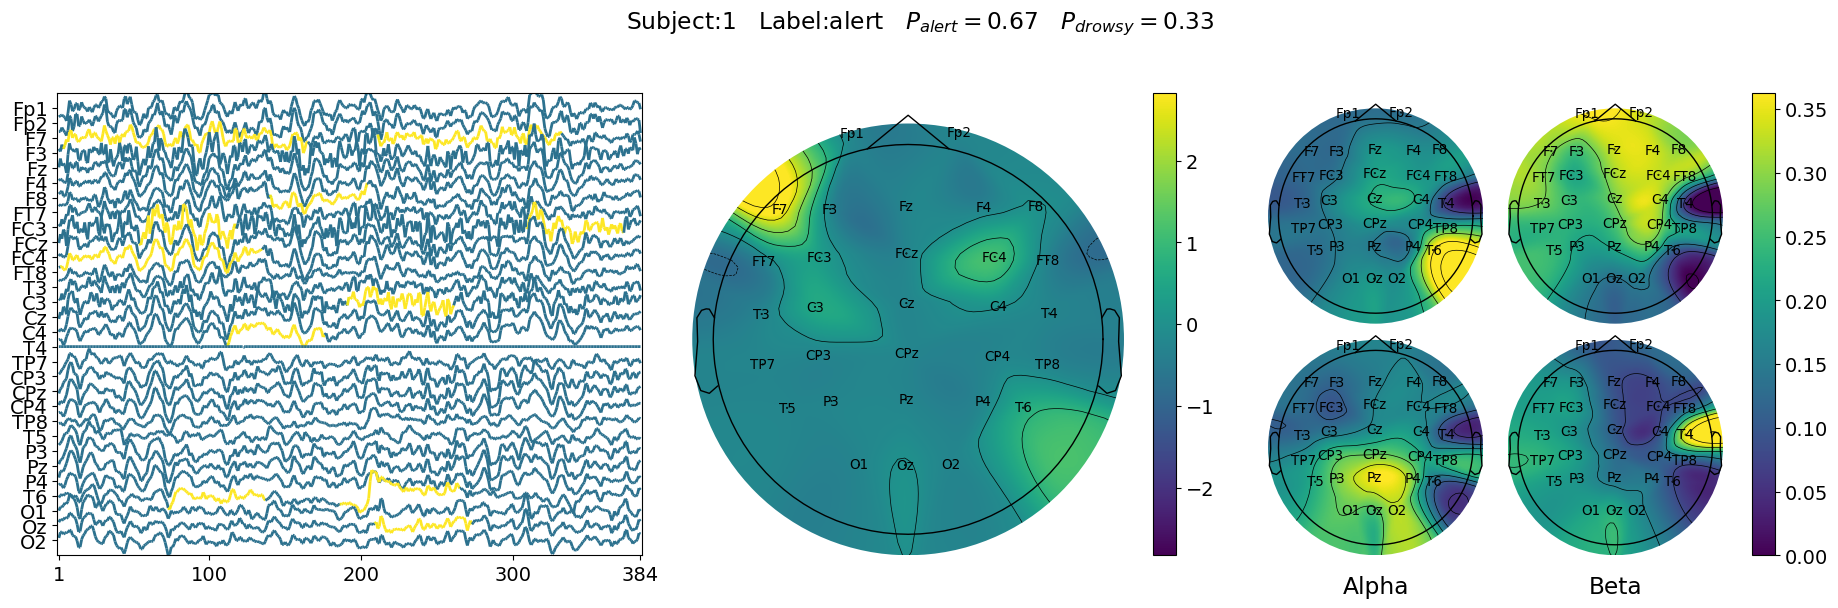

In [93]:
plt.show()